#                               **Calculating the Probability of Default**  


###  Begin by importing necessary libraries

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

### Load and inspect the data

In [23]:
data = pd.read_csv(r'C:\Users\georg\Downloads\Task 3 and 4_Loan_Data (2).csv')
data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


### Prepare the independent variables in the vector (X) and the dependent variable (y)


In [24]:
X = data[['fico_score', 'years_employed', 'credit_lines_outstanding', 'loan_amt_outstanding', 'total_debt_outstanding', 'income']]
y = data['default']

### Inspect correlation matrix to identify highly correlated variables

In [25]:
X.corr()

,fico_score,years_employed,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income
fico_score,1.000000,0.255873,-0.258177,-0.031373,-0.232246,-0.010528
years_employed,0.255873,1.000000,-0.087900,-0.158416,-0.174353,0.001814
credit_lines_outstanding,-0.258177,-0.087900,1.000000,0.080249,0.852210,0.022272
loan_amt_outstanding,-0.031373,-0.158416,0.080249,1.000000,0.397403,0.835815
total_debt_outstanding,-0.232246,-0.174353,0.852210,0.397403,1.000000,0.394397
income,-0.010528,0.001814,0.022272,0.835815,0.394397,1.000000


### It is clear that two variables exhibit strong correlation. We plot their relationship.

In [26]:
def scatterplot(ax, x, y):
    lin = linregress(x, y)
    m = lin.slope
    b = lin.intercept
    x_lin = np.linspace(x.min(), x.max(), 100)  # Change to 100 points for smoother line
    ax.plot(x_lin, m * x_lin + b, 'r', label='Regression Line')
    ax.scatter(x, y, alpha=0.6)
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    ax.set_title(f'Scatter Plot of {x.name} vs {y.name}')
    ax.grid()
    ax.legend()

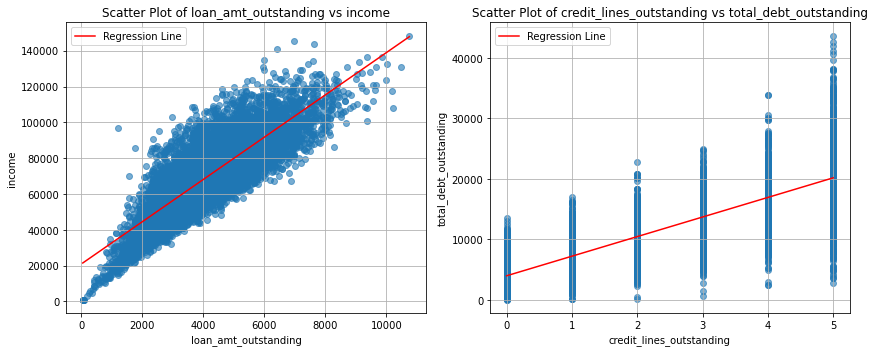

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
scatterplot(axs[0], X['loan_amt_outstanding'], X['income'])
scatterplot(axs[1], X['credit_lines_outstanding'], X['total_debt_outstanding'])
plt.tight_layout()
plt.show()

#### It seems that customers with higher income possess a larger amount of outstanding loans and customers with a larger total debt possess more credit lines outstanding.

#### To avoid collinearity we dismiss the two variables ('credit_lines_outstanding','loan_amt_outstanding') in our analysis.  

#### In dismissing these variables we avoid running into issues that arise from highly correlated variables when executing regression methods and we achieve a substantial simplification of our model.

### Prepare the feature matrix (X) and target (y) for our uncorrellated variables and normalize the X vector.

In [28]:
X = data[['fico_score', 'years_employed', 'total_debt_outstanding', 'income']]
y = data['default']

Xnorm=(X-X.mean())/X.std()

### At this point we are set to execute our logistic regression model. 

#### Before we proceed, there are a couple aspects we should comment on. 

#### First, we need to make sure that the train set we select is an accurate representation of our data. To that end, we employ a 10-fold cross-validation technique which splits the data set into 4 independent training subsets and tests them on the remaining set. Comparing the results we can deduce whether our fit is stable and reliable. 

#### Second, it is important to select an appropriate fraction of our data to train. Larger train sets will in general yield better fits, but one has to compromise assessing their predictability. To that end, we consider different test sizes and evaluate their accuracy metrics. 

In [29]:
model = LogisticRegression()

test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

coefficients_mean_dict = {}
coefficients_std_dict = {}
intercepts_dict = {}
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}

for test_size in test_sizes:
    coefficients_list = []
    intercepts_list = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    
    for random_state in range(5):
        
        X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, test_size=test_size, random_state=random_state)
      
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        coefficients_list.append(model.coef_[0])
        intercepts_list.append(model.intercept_[0])

        accuracy_list.append(accuracy_score(y_test, y_pred))
        precision_list.append(precision_score(y_test, y_pred))
        recall_list.append(recall_score(y_test, y_pred))
        f1_list.append(f1_score(y_test, y_pred))

    coefficients_mean_dict[test_size] = np.mean(coefficients_list, axis=0)
    coefficients_std_dict[test_size] = np.std(coefficients_list, axis=0)
    intercepts_dict[test_size] = np.mean(intercepts_list, axis=0)
    accuracy_dict[test_size] = np.mean(accuracy_list)
    precision_dict[test_size] = np.mean(precision_list)
    recall_dict[test_size] = np.mean(recall_list)
    f1_dict[test_size] = np.mean(f1_list)

for test_size in test_sizes:
    print(f"Test size: {test_size}")
    print(f"Mean Coefficients: {coefficients_mean_dict[test_size]}")
    print(f"Std of Coefficients: {coefficients_std_dict[test_size]}")
    print(f"Mean Intercept: {intercepts_dict[test_size]}")
    print(f"Mean Accuracy: {accuracy_dict[test_size]:.4f}")
    print(f"Mean Precision: {precision_dict[test_size]:.4f}")
    print(f"Mean Recall: {recall_dict[test_size]:.4f}")
    print(f"Mean F1 Score: {f1_dict[test_size]:.4f}")
    print("---------------------------------------------------")


Test size: 0.1
Mean Coefficients: [-0.80048198 -0.70688896  9.32127842 -5.67035728]
Std of Coefficients: [0.03456382 0.01095591 0.02422631 0.01764802]
Mean Intercept: -8.371697658958821
Mean Accuracy: 0.9824
Mean Precision: 0.9671
Mean Recall: 0.9371
Mean F1 Score: 0.9516
---------------------------------------------------
Test size: 0.2
Mean Coefficients: [-0.79512299 -0.68321126  9.04715687 -5.48901906]
Std of Coefficients: [0.03934469 0.01161235 0.05226679 0.0469452 ]
Mean Intercept: -8.140448173259418
Mean Accuracy: 0.9842
Mean Precision: 0.9701
Mean Recall: 0.9443
Mean F1 Score: 0.9569
---------------------------------------------------
Test size: 0.3
Mean Coefficients: [-0.77038539 -0.66877519  8.74219517 -5.30225969]
Std of Coefficients: [0.04905166 0.03320429 0.06667772 0.07712617]
Mean Intercept: -7.886578038481294
Mean Accuracy: 0.9855
Mean Precision: 0.9736
Mean Recall: 0.9481
Mean F1 Score: 0.9607
---------------------------------------------------
Test size: 0.4
Mean Coeff

### The evaluation metrics are for the most part similar, so a good strategy would be to select test size 30% which offers a good compromise between fitting and predictability.

### We finally employ our model to a new customer. Inserting the customer features we are able to obtain the probability of default and decide whether to grant a new loan.

In [47]:
coefficients = coefficients_mean_dict[0.3]
intercept = intercepts_dict[0.3]

fico_score=800
years_employed=10
total_debt_outstanding=40000
income=180000

new_customer = np.array([fico_score, years_employed, total_debt_outstanding, income])

new_customer_norm=(new_customer-X.mean())/X.std()

log_odds = np.dot(coefficients, new_customer_norm) + intercept

probability = 100*(1 / (1 + np.exp(-log_odds)))

print(f"Predicted Probability of Default: {probability:.2f}%")

Predicted Probability of Default: 48.57%


### Calculated probability of default for a customer with features:
#### Fico Score: 800
#### years employed: 10
#### total debt outstanding: 40.000 
#### income:180.000 
#### is 48.57%